In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.filters
import numpy as np

from scipy import signal
from scipy.signal import butter, lfilter, spectrogram
from scipy.io import wavfile
import IPython.display

spectrogram utils.

In [7]:
# This code credit to https://github.com/keithito/tacotron/blob/8edcd55b3f08f0492340e8b3ee60a693138f5473/util/audio.py

def spectrogram(y, hparams):
  D = _stft(preemphasis(y,hparams), hparams)
  S = _amp_to_db(np.abs(D)) - hparams['ref_level_db']
  return _normalize(S, hparams)

def inv_spectrogram(spectrogram, hparams):
  '''Converts spectrogram to waveform using librosa'''
  S = _db_to_amp(_denormalize(spectrogram, hparams) + hparams['ref_level_db'])  # Convert back to linear
  return inv_preemphasis(_griffin_lim(S ** hparams['power'], hparams), hparams)          # Reconstruct phase

def preemphasis(x,hparams):
  return signal.lfilter([1, -hparams['preemphasis']], [1], x)

def inv_preemphasis(x, hparams):
  return signal.lfilter([1], [1, -hparams['preemphasis']], x)

def melspectrogram(y,hparams,_mel_basis):
  D = _stft(preemphasis(y, hparams), hparams)
  S = _amp_to_db(_linear_to_mel(np.abs(D),_mel_basis)) - hparams['ref_level_db']
  return _normalize(S, hparams)

def find_endpoint(wav, hparams, threshold_db=-40, min_silence_sec=0.8):
  window_length = int(hparams['sample_rate'] * min_silence_sec)
  hop_length = int(window_length / 4)
  threshold = _db_to_amp(threshold_db)
  for x in range(hop_length, len(wav) - window_length, hop_length):
    if np.max(wav[x:x+window_length]) < threshold:
      return x + hop_length
  return len(wav)

def _griffin_lim(S, hparams):
  '''librosa implementation of Griffin-Lim
  Based on https://github.com/librosa/librosa/issues/434
  '''
  angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
  S_complex = np.abs(S).astype(np.complex)
  y = _istft(S_complex * angles,hparams)
  for i in range(hparams['griffin_lim_iters']):
    angles = np.exp(1j * np.angle(_stft(y, hparams)))
    y = _istft(S_complex * angles, hparams)
  return y

def _stft(y, hparams):
  n_fft, hop_length, win_length = _stft_parameters(hparams)
  return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

def _istft(y, hparams):
  _, hop_length, win_length = _stft_parameters(hparams)
  return librosa.istft(y, hop_length=hop_length, win_length=win_length)

def _stft_parameters(hparams):
  n_fft = (hparams['num_freq'] - 1) * 2
  hop_length = int(hparams['frame_shift_ms'] / 1000 * hparams['sample_rate'])
  win_length = int(hparams['frame_length_ms'] / 1000 * hparams['sample_rate'])
  return n_fft, hop_length, win_length

def _linear_to_mel(spectrogram, _mel_basis):
  return np.dot(_mel_basis, spectrogram)

def _build_mel_basis(hparams):
  n_fft = (hparams['num_freq'] - 1) * 2
  return librosa.filters.mel(hparams['sample_rate'], n_fft, n_mels=hparams['num_mels'], fmin = hparams['fmin'], fmax=hparams['fmax'])

def _amp_to_db(x):
  return 20 * np.log10(np.maximum(1e-5, x))

def _db_to_amp(x):
  return np.power(10.0, x * 0.05)

def _normalize(S, hparams):
  return np.clip((S - hparams['min_level_db']) / -hparams['min_level_db'], 0, 1)

def _denormalize(S, hparams):
  return (np.clip(S, 0, 1) * -hparams['min_level_db']) + hparams['min_level_db']

testing 1 wavfile (birdsong)

In [4]:
rate, data = wavfile.read('../data/165_s_22.wav')
rate, data.shape

(40000, (3556530,))

In [5]:
# original wav
IPython.display.Audio(data=data, rate=rate)

#### with scipy.signal.spectrogram.
plotting spectrogram

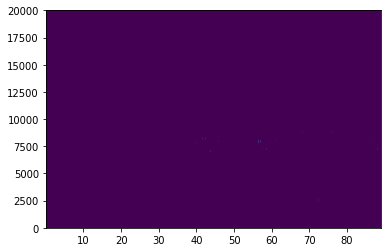

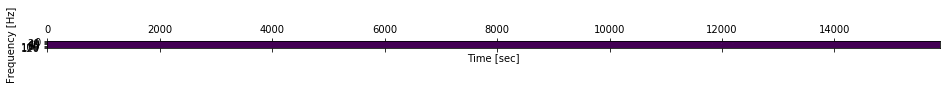

In [15]:
frequencies, times, spectrogram = signal.spectrogram(data, rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.matshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Sxx = signal.spectrogram(x, fs, nfft=1028)
plt.pcolormesh(t, f[0:20], Sxx[0:20])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### with librosa.  
declaring hyperparameters.

In [8]:
hparams = {
    'species':'ST',
    # filtering
    'highcut':3000,
    'lowcut':10,
    
    # spectrograms
    'mel_filter': True, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'num_freq':2048, # how many channels to use in a spectrogram 
    'sample_rate':44100, # what rate are your WAVs sampled at?
    'preemphasis':0.97, 
    'frame_shift_ms':20, # step size for fft
    'frame_length_ms':50, # frame length for fft
    'min_level_db':-100, # minimum threshold db for computing spe 
    'ref_level_db':20, # reference db for computing spec
    'sample_rate':rate, # sample rate of your data
    'fmin': 10, # low frequency cutoff for mel filter
    'fmax': 15000, # high frequency cutoff for mel filter
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,
    
}

building mel basis

In [9]:
_mel_basis = _build_mel_basis(hparams) # build a basis function if you are using a mel spectrogram
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))

/home/AD/kachiem/miniconda3/envs/tf-conda/lib/python3.7/site-packages/librosa/filters.py:222: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/AD/kachiem/miniconda3/envs/tf-conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/AD/kachiem/miniconda3/envs/tf-conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


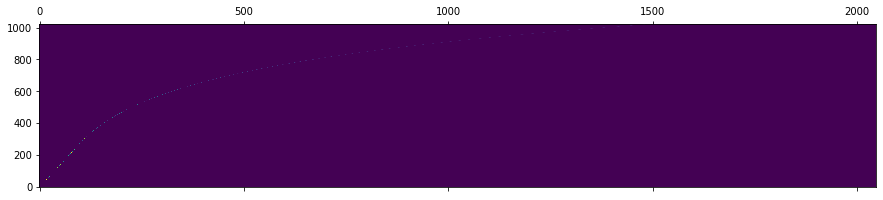

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,3))
ax.matshow(_mel_basis, origin='lower', aspect='auto')
plt.show()

In [11]:
spec = spectrogram(data, hparams)
spec.shape

(2048, 4446)

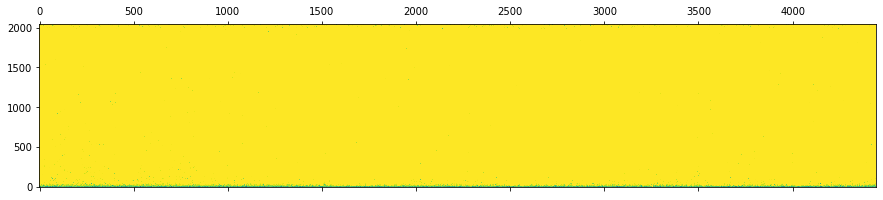

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,3))
ax.matshow(spec, origin='lower', aspect='auto')
plt.show()